# CSCI 5561 Homework 2 (10% of the overall grade)

The goal of this assignment is to stitch images and merge them into a coherent image using homographies.
We will provide you a few input images from a planar scene (a poster).
Each image contains a partial observation of the full poster.
You will be given pairwise correspondences between the images, and use them to compute the homography transformation using multiple techniques.
You will also use the image warping methods from your HW1.

You are welcome and encouraged to use any  learning material to reinforce the concepts we learned in class (for example, [this one](https://colab.research.google.com/github/farrokhkarimi/OpenCV/blob/master/Getting_Started_with_OpenCV.ipynb)). But you can not use others' code or functions.


We'll have 4 questions + 1 bonus question in total. Credits for each question are listed below.


This homework will be graded according to the following honor code:
* If you copy/paste code from the internet, AI code assistants etc., this constitutes cheating. The penalty is you don't learn and you will probably have a very hard time with the later assignments (they will use this information and will be harder). If your tendency is to go down this path, you should probably not take this course.

* If you cheat in an assignment, you will receive zero. If it is your second offense, you fail the class. All cheating will be reported.

_By attempting this assignment, you agree to the code above._

**Submission Deadline**

* By Friday Oct 4th, midnight: Full credit
* By Sunday Oct 6th, midnight: Full credit if you need DRC accomodations or have a valid excuse (which usually means doctor's note). Otherwise you get 75% of the grade. No late submissions beyond this point.

## Introduction to the problem

Before we dive into the extact problem we try to solve, let's visualize the data to get some intuition. Let's see what the raw images look like, and the expected final outcome as well.

Meanwhile, we also visualize the extracted features from each image. To simplify the problem, we manually annotate the correspondence and save them into the pickle files. Each keypoint is visualized as one dot with the same name among different images.

In [ ]:
# first we start by importing necessary libraries
import os
import cv2
import torch
import pickle
import itertools
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from skimage.metrics import structural_similarity as ssim

if not os.path.exists('00.jpg'):
    !gdown 1ly2qbDSAYKBl4ezLAFoLV3PLzoW2bQV_ -O 00.jpg
if not os.path.exists('01.jpg'):
    !gdown 1hoU9v0Mo_mnFllxbqy75mA6DL7WTzMHC -O 01.jpg
if not os.path.exists('02.jpg'):
    !gdown 1uig4ZbVGP4AjlqXC3klcVAEpzfOY1viT -O 02.jpg
if not os.path.exists('03.jpg'):
    !gdown 1B5NKkmc5Vvz4moC-UO9xfWpNcb3cFBEN -O 03.jpg
if not os.path.exists('00.pkl'):
    !gdown 1Il7n6HSBS_gjKiwlD_p58XPivtQWcq3C -O 00.pkl
if not os.path.exists('01.pkl'):
    !gdown 1nMVjyLFAYoWEgilZCwz7aN30yWP4WMCm -O 01.pkl
if not os.path.exists('02.pkl'):
    !gdown 1ygidd67rhip59myv5ZW3o-1Z4FRV0hdh -O 02.pkl
if not os.path.exists('03.pkl'):
    !gdown 1-plhLOzJt9UUP9ktCRbpI2Ay_XeG_dd_ -O 03.pkl
if not os.path.exists('prob5.pkl'):
    !gdown 1-OI2YOT0haxH5kXeXYsNmPpJ_UCiCJ4W -O prob5.pkl

Downloading...
From: https://drive.google.com/uc?id=1ly2qbDSAYKBl4ezLAFoLV3PLzoW2bQV_
To: /content/00.jpg
100% 2.97M/2.97M [00:00<00:00, 176MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hoU9v0Mo_mnFllxbqy75mA6DL7WTzMHC
To: /content/01.jpg
100% 2.42M/2.42M [00:00<00:00, 56.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uig4ZbVGP4AjlqXC3klcVAEpzfOY1viT
To: /content/02.jpg
100% 2.31M/2.31M [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B5NKkmc5Vvz4moC-UO9xfWpNcb3cFBEN
To: /content/03.jpg
100% 2.72M/2.72M [00:00<00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Il7n6HSBS_gjKiwlD_p58XPivtQWcq3C
To: /content/00.pkl
100% 450/450 [00:00<00:00, 1.46MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nMVjyLFAYoWEgilZCwz7aN30yWP4WMCm
To: /content/01.pkl
100% 459/459 [00:00<00:00, 2.04MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ygidd67rhip59myv5ZW3o-1Z4FRV0hdh
To: /content/02.pkl
100% 397/397 [00:00<00:

In [ ]:
def read_image_and_features(path, size):
    """
    Read an image from a file and resizes it.

    Args:
        path (str): The path to the image file.
        size (tuple): The size of the resized image.

    Returns:
        numpy.ndarray: The resized image.
    """
    # Read the image
    image = cv2.imread(path)
    H, W, _ = image.shape

    # Resize the image
    image = cv2.resize(image, size)

    # Note that the image is in BGR format, convert it to RGB for displaying with matplotlib.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pkl_filename = os.path.splitext(path)[0] + ".pkl"

    with open(pkl_filename, 'rb') as pkl_file:
        data = pickle.load(pkl_file)

    kp, des = data["kp"], data["des"]
    kp = kp * np.array([[size[0] / W, size[1] / H]])

    return image, {des[i] : (kp[i, 0], kp[i, 1]) for i in range(len(des))}


# ------------------------------------------------------------------
imgsize = (640, 480)
img_paths = [
    '00.jpg',
    '01.jpg',
    '02.jpg',
    '03.jpg',
]

imgs = []
img_features = []

for path in img_paths:
  img, features = read_image_and_features(path, imgsize)
  imgs.append(img)
  img_features.append(features)

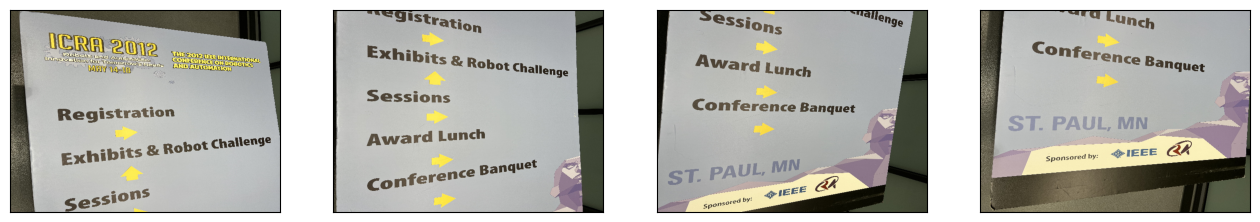

In [ ]:
#@title Visualize raw images.
fig, axs = plt.subplots(1, 4, figsize=(16, 12))
for i in range(4):
    axs[i].imshow(imgs[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

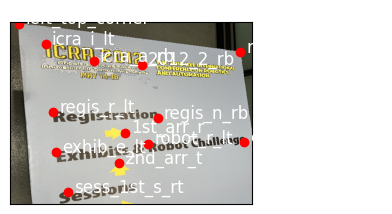

In [ ]:
#@title Visualize features
def display_img_and_features(img, features):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.imshow(img)
    for label, (x, y) in features.items():
        ax.scatter(x, y, color='red')
        ax.text(x + 16, y, label, color='white', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()

display_img_and_features(imgs[0], img_features[0])

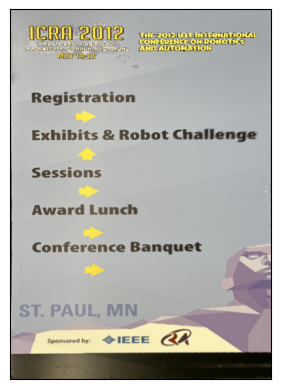

In [ ]:
#@title Visualize the final output.
with open('prob5.pkl', 'rb') as f:
    correct_image = pickle.load(f)
fig, ax = plt.subplots()
ax.imshow(correct_image)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Visualize correspondence

Also, let's visualize the correspondence between the first and the second image.

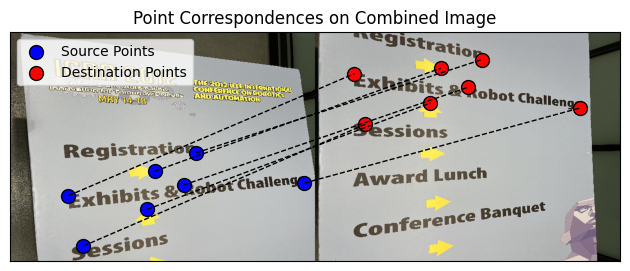

In [ ]:
def compute_correspondence(src_features, dst_features):
    """
    Compute the correspondence between two sets of features.
    Args:
        src_features: dict - {description : (x, y)}
        dst_features: dict - {description : (x, y)}

    Returns:
        (numpy.ndarray: Mx2 src_points, numpy.ndarray: Mx2 dst_points)
        such that if src_description == dst_description then
        there exists an index, i, such that src_points[i] == src_features[src_description]
        and dst_points[i] == dst_description[src_description].
    """

    src_points = []
    dst_points = []

    # Find common descriptions
    common_descriptions = set(src_features.keys()) & set(dst_features.keys())

    # Collect corresponding points
    for description in common_descriptions:
        src_points.append(src_features[description])
        dst_points.append(dst_features[description])

    src_points = np.array(src_points)
    dst_points = np.array(dst_points)

    assert src_points.shape == dst_points.shape, \
        "Mismatch in number of corresponding points: src_points shape {} != dst_points shape {}".format(
            src_points.shape, dst_points.shape
        )

    return (src_points, dst_points)


def display_correspondence(src_features, dst_features, src_image, dst_image):
    src_points, dst_points = compute_correspondence(src_features, dst_features)

    combined_image = np.hstack((src_image, dst_image))
    dst_points_adjusted = dst_points + np.array([src_image.shape[1], 0])

    fig, ax = plt.subplots()
    ax.imshow(combined_image)

    ax.scatter(src_points[:, 0], src_points[:, 1], color='blue', label='Source Points', s=100, edgecolors='k')
    ax.scatter(dst_points_adjusted[:, 0], dst_points_adjusted[:, 1], color='red', label='Destination Points', s=100, edgecolors='k')

    for src, dst in zip(src_points, dst_points_adjusted):
        ax.plot([src[0], dst[0]], [src[1], dst[1]], 'k--', lw=1)

    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('Point Correspondences on Combined Image')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


src_index, dst_index = 0, 1
src_points, dst_points = compute_correspondence(img_features[src_index], img_features[dst_index])
display_correspondence(img_features[src_index], img_features[dst_index], imgs[src_index], imgs[dst_index])

## Problem 1: Homography (4 correspondences) (2 credits)

In this part, we find N corespondeces between two dictionaries of features between two images. Then with 4 pairs of correspondence, we solve the
homography analytically.

**compute_homography_four:**

**Input:**
- `src_pts`: Correspondence points from the source image. $4 \times 2$
- `dst_pts`: Correspondence points from the target image. $4 \times 2$

**Output:**
- `M`: a 3x3 matrix as the homography matrix.

You can visually check your implementation by running the following code block.

In [ ]:
#@title Utility function: display homography projection

def display_homography_projection(H, src_points, dst_points, src_image, dst_image):

    # Add homogeneous coordinate
    src_points_h = np.hstack((src_points, np.ones((len(src_points), 1))))

    # Project source points to the destination space
    projected_points_h = (H @ src_points_h.T).T
    projected_points_h = projected_points_h / projected_points_h[:, 2][:, None]
    projected_points = projected_points_h[:, :2]

    combined_image = np.hstack((src_image, dst_image))
    dst_points_adjusted = dst_points + np.array([src_image.shape[1], 0])
    projected_points_adjusted = projected_points + np.array([src_image.shape[1], 0])

    fig, ax = plt.subplots()
    ax.imshow(combined_image)

    plt.scatter(src_points[:, 0], src_points[:, 1], c='r', marker='o', label='Source Points', s=100, edgecolors='k')
    plt.scatter(dst_points_adjusted[:, 0], dst_points_adjusted[:, 1], c='g', marker='o', label='Destination Points', s=100, edgecolors='k')
    plt.scatter(projected_points_adjusted[:, 0], projected_points_adjusted[:, 1], c='b', marker='x', label='Projected Points', s=100, edgecolors='k')

    for src, proj in zip(src_points, projected_points_adjusted):
        plt.plot([src[0], proj[0]], [src[1], proj[1]], 'k--', lw=1)

    for dst, proj in zip(dst_points_adjusted, projected_points_adjusted):
        plt.plot([dst[0], proj[0]], [dst[1], proj[1]], 'k--', lw=1)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('Combined Image with Homography Projection')
    plt.legend()
    plt.show()


def display_homography_warp(H, src_image, dst_image):
    im_dst = cv2.warpPerspective(src_image, H, (dst_image.shape[1], dst_image.shape[0]))
    blended_image = cv2.addWeighted(dst_image, 0.75, im_dst, 0.75, 0)

    fig, ax = plt.subplots()
    ax.imshow(blended_image)
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('Warped Source Image Overlayed on Destination Image')
    plt.show()

def transform(H, points):
    points_h = np.hstack((points, np.ones((len(points), 1))))
    dist_points_proj = (H @ points_h.T).T
    dist_points_proj = dist_points_proj / dist_points_proj[:, 2][:, None]
    return dist_points_proj[:, :2]

def projection_error(H, src_points, dst_points):
    return np.mean((dst_points - transform(H, src_points)) ** 2, axis=1)

<ipython-input-8-b0c00a1a3d81>:22: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(projected_points_adjusted[:, 0], projected_points_adjusted[:, 1], c='b', marker='x', label='Projected Points', s=100, edgecolors='k')


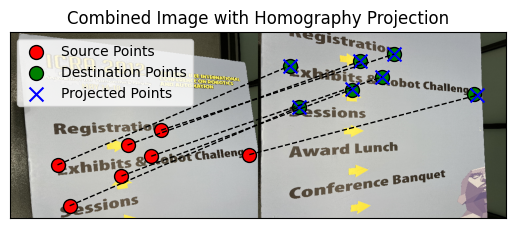

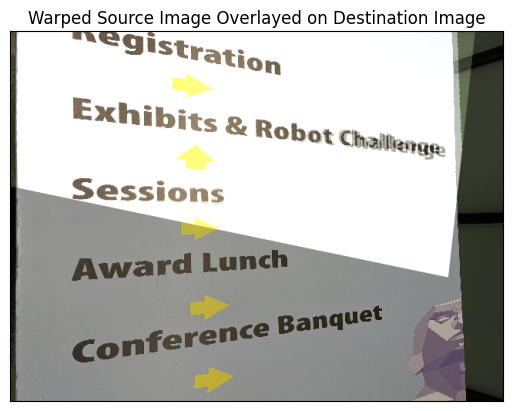

In [ ]:
def compute_homography_four(src_points, dst_points):
    """
    Compute the homography matrix that maps the points in the first image to the points in the second image.
    Args:
        src_points: 4x2 numpy array of points in the first image.
        dst_points: 4x2 numpy array of points in the second image.

    Returns:
        numpy.ndarray: The homography matrix. 3x3 numpy array.

    Compute the homography matrix H that maps the points in the first image to the points in the second image.
    Compute the homography by minimizing the projected distance between the corresponding points.
    Hint: rearrange the system such that it fits this form Ax = b A is 8x8, x is 8x1, and b is 8x1
    Hint: Use np.linalg.inv to solve Ax = b
    """

    ############################################################################
    #                               BEGIN OF YOUR CODE                         #
    ############################################################################
    A = []
    for sp, dp in zip(src_points, dst_points):
        A.append([sp[0], sp[1], 1, 0, 0, 0, -sp[0]*dp[0], -sp[1]*dp[0], -dp[0]])
        A.append([0, 0, 0, sp[0], sp[1], 1, -sp[0]*dp[1], -sp[1]*dp[1], -dp[1]])
    A = np.array(A)
    X = np.linalg.inv(A[:,:-1]) @ (A[:,-1][:,np.newaxis] * -1)
    X = np.append(X, 1)
    H = np.reshape(X, (3,3))

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    return H

src_index, dst_index = (0, 1)
src_points, dst_points = compute_correspondence(img_features[src_index], img_features[dst_index])
H = compute_homography_four(src_points[:4, :], dst_points[:4, :])

display_homography_projection(H, src_points, dst_points, imgs[src_index], imgs[dst_index])
display_homography_warp(H, imgs[src_index], imgs[dst_index])

# Comment out this line to verify your method.
assert np.sum(projection_error(H, src_points, dst_points) < 1) >= 4, "Not Close Enough : {} < .001 for at least 4 points".format(projection_error(H, src_points, dst_points))

## Problem 2: Homography (n correspondences) (2 credits)

Now we assume N pairs of correspondence are given.
We solve the homography by using Least Squares.

**compute_homography_N:**

**Input:**
- `src_pts`: Correspondence points from the source image. $N \times 2$
- `trg_pts`: Correspondence points from the target image. $N \times 2$

**Output:**
- `M`: a 3x3 matrix as the homography matrix.



<ipython-input-8-b0c00a1a3d81>:22: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(projected_points_adjusted[:, 0], projected_points_adjusted[:, 1], c='b', marker='x', label='Projected Points', s=100, edgecolors='k')


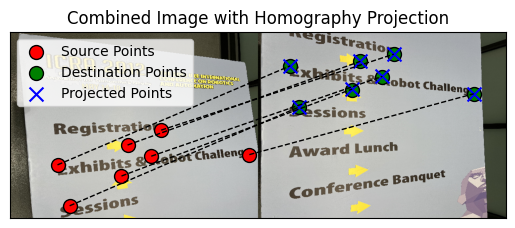

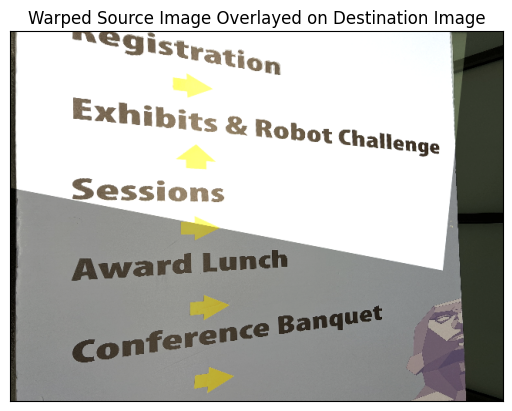

In [ ]:
def compute_homography_N(src_points, dst_points):
    """
    Compute the homography matrix that maps the points in the first image to the points in the second image.
    Args:
        src_points: Nx2 numpy array of points in the first image.
        dst_points: Nx2 numpy array of points in the second image.

    Returns:
        numpy.ndarray: The homography matrix. 3x3 numpy array.

    Compute the homography matrix H that maps the points in the first image to the points in the second image.
    Compute the homography by minimizing the projected distance between the corresponding points.
    Hint: rearrange the system such that it fits this form Ax = b A is 8x8, x is 8x1, and b is 8x1
    Hint: Use np.linalg.inv to solve Ax = b
    """

    ############################################################################
    #                               BEGIN OF YOUR CODE                         #
    ############################################################################
    A = []
    for sp, dp in zip(src_points, dst_points):
        A.append([sp[0], sp[1], 1, 0, 0, 0, -sp[0]*dp[0], -sp[1]*dp[0], -dp[0]])
        A.append([0, 0, 0, sp[0], sp[1], 1, -sp[0]*dp[1], -sp[1]*dp[1], -dp[1]])
    A = np.array(A)
    b = (A[:,-1][:,np.newaxis] * -1)
    A = A[:,:-1]
    X = np.linalg.inv(A.T @ A) @ A.T @ b
    X = np.append(X, 1)
    H = np.reshape(X, (3,3))

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    return H

src_index, dst_index = 0, 1
src_points, dst_points = compute_correspondence(img_features[src_index], img_features[dst_index])
H = compute_homography_N(src_points, dst_points)

display_homography_projection(H, src_points, dst_points, imgs[src_index], imgs[dst_index])
display_homography_warp(H, imgs[src_index], imgs[dst_index])

# Comment out this line to verify your method.
assert np.sum(projection_error(H, src_points, dst_points) < 1) >= src_points.shape[0] - 2, "Not Close Enough : {} < 1 for {} of them".format(projection_error(H, src_points, dst_points), src_points.shape[0] - 2)


## Problem 3: Homography (n correspondences + RANSAC)  (2 credits)

Now we assume n pair of correspondence are given.
We solve the homography by using the RANSAC algorithm.

**compute_homography_RANSAC**

**Input:**
- `src_pts`: Correspondence points from the source image. $4 \times 2$
- `trg_pts`: Correspondence points from the target image. $4 \times 2$

**Output:**
- `M`: a 3x3 matrix as the homography matrix.

[[ 9.97345914e-01 -7.73700765e-02 -1.23886241e+01]
 [ 2.14720064e-01  9.66036385e-01 -2.70049868e+02]
 [ 4.72793484e-05  3.91165433e-06  1.00000000e+00]]


<ipython-input-8-b0c00a1a3d81>:22: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(projected_points_adjusted[:, 0], projected_points_adjusted[:, 1], c='b', marker='x', label='Projected Points', s=100, edgecolors='k')


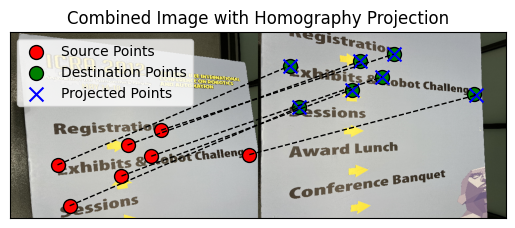

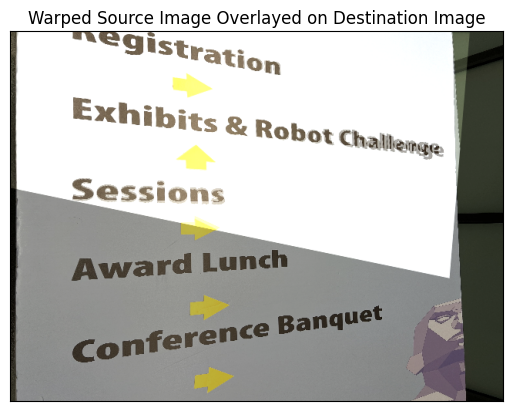

In [ ]:
def compute_homography_RANSAC(src_points, dst_points, iters=1000):
    """
    Compute the homography matrix that maps the points in the first image to the points in the second image.
    Args:
        src_points: Nx2 numpy array of points in the first image.
        dst_points: Nx2 numpy array of points in the second image.

    Returns:
        numpy.ndarray: The homography matrix. 3x3 numpy array.

    Compute Homography matrix with 4 point algorithim from 4 random points, note the projection error -- keep track of the best
    """
    ############################################################################
    #                               BEGIN OF YOUR CODE                         #
    ############################################################################
    src_points_h = np.hstack((src_points, np.ones((len(src_points), 1))))
    dst_points_h = np.hstack((dst_points, np.ones((len(dst_points), 1))))
    max_inliers = 0
    best_H = None
    n = src_points_h.shape[0]
    for i in range(iters):
      pts = np.random.choice(n, 4, replace=False)
      H = compute_homography_four(src_points[pts, :], dst_points[pts, :])

      errors = dst_points_h - (H @ src_points_h.T).T
      # print("bef", errors)
      # errors = (errors / errors[:, 2][:, None])[:, :2] #de-homogeonize
      # print(errors)
      errors = np.linalg.norm(errors, axis=1)
          #np.linalg.norm(src_points_h - (np.linalg.inv(H) @ dst_points_h.T).T, axis=1)
      inliers = np.sum(errors < 25)
      if inliers > max_inliers:
        max_inliers = inliers
        best_H = H

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    print(best_H)
    return best_H

src_index, dst_index = 0, 1
src_points, dst_points = compute_correspondence(img_features[src_index], img_features[dst_index])
H = compute_homography_RANSAC(src_points, dst_points)

display_homography_projection(H, src_points, dst_points, imgs[src_index], imgs[dst_index])
display_homography_warp(H, imgs[src_index], imgs[dst_index])

# Comment out this line to verify your method.
assert np.sum(projection_error(H, src_points, dst_points) < 1) >= src_points.shape[0] - 2, "Not Close Enough : {} < 25 for {} of them".format(projection_error(H, src_points[:4, :], dst_points[:4, :]), src_points.shape[0] - 2)

## Problem 4: Homography (n correspondences. Reprojection)  (Bonus: 2 credits)

Assume n pair of correspondence are given.
Now we do it in a little bit different way.
We will compute the homography that minimizes the reprojection error. To do so, we start with an initial estimate and refine it iteratively: we project the correspondence points to the target image, and  calculate the reprojection error.
We use that error as a loss function, and calculate the gradient with respect to our homography matrix. We then update our homography matrix based on the gradient.
By keep doing iteration, we get our homography.

**compute_homography_reproj**

**Input:**
- `src_pts`: Correspondence points from the source image. $4 \times 2$
- `trg_pts`: Correspondence points from the target image. $4 \times 2$

**Output:**
- `M`: a 3x3 matrix as the homography matrix.

Hints:
- Use homography from the previous question as your initialization.
- You may use the reprojection error as the loss term.
- Use Adam as your optimizer.
- Since H[3, 3] is a constant (1), only parameterize the other 8 elements as the variables.
- Some hyper-params for reference: learning rate 1e-4, iterations: 1000

In [ ]:
import torch

def project_torch(M, src_pts_h, trg_pts_h):
    trg_pts_proj = (M @ src_pts_h.T).T
    trg_pts_proj = trg_pts_proj / trg_pts_proj[:, 2][:, None]# Normalize
    return trg_pts_proj


def compute_homography_reproj(src_pts, trg_pts, H_init=np.eye(3)):
    """
    Compute the homography matrix that maps the points in the first image to the points in the second image.
    Args:
        src_points: Nx2 numpy array of points in the first image.
        dst_points: Nx2 numpy array of points in the second image.
        H_init: Initialized homography matrix parameter.

    Returns:
        numpy.ndarray: The homography matrix. 3x3 numpy array.

    Compute Homography matrix by calculating the gradient of the matrix.
    """
    ############################################################################
    #                               BEGIN OF YOUR CODE                         #
    ############################################################################
    # Replace the next line with your code
    H = np.eye(3)

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    return H

src_index, dst_index = 0, 1
src_points, dst_points = compute_correspondence(img_features[src_index], img_features[dst_index])
H_init = compute_homography_four(src_points, dst_points)
display_homography_projection(H_init, src_points, dst_points, imgs[src_index], imgs[dst_index])
display_homography_warp(H_init, imgs[src_index], imgs[dst_index])
print("Reprojection Error init: ", projection_error(H_init, src_points, dst_points).mean())

H_reproj = compute_homography_reproj(src_points, dst_points, H_init)
display_homography_projection(H_reproj, src_points, dst_points, imgs[src_index], imgs[dst_index])
display_homography_warp(H_reproj, imgs[src_index], imgs[dst_index])
print("Reprojection Error after: ", projection_error(H_reproj, src_points, dst_points).mean())

# Comment out this line to verify your method.
# assert np.sum(projection_error(H_reproj, src_points, dst_points) < 1) >= src_points.shape[0] - 2, "Not Close Enough : {} < 25 for {} of them".format(projection_error(H, src_points[:4, :], dst_points[:4, :]), src_points.shape[0] - 2)


LinAlgError: Last 2 dimensions of the array must be square

## Problem 5: Image stitching (4 credits)

Now we are ready to stitch images.

You are expected to implement the function `stitch_images(src_pts, trg_pts)`.

In [ ]:
#@title Copy the functions from HW1.

def my_bilinear_interpolate(img, points):
    ############################################################################
    # TODO: Implement your vectorized bilinear interpolation function
    #
    # Arguments
    # ----------
    # img: (H, W, 3)
    #       Input image
    # points: (N, 2)
    #       The query points to sample the image at. Each row is a point (x, y)
    #
    # Return
    # -------
    # dst: (N, 3)
    #       The interpolated value for all query points
    ############################################################################
    # Replace the next line with your code
    X, Y = points[:,0], points[:,1]
    X1 = np.floor(X).astype(np.int64)
    X2 = X1+1
    Y1 = np.floor(Y).astype(np.int64)
    Y2 = Y1+1

    # out of bound points: delete
    H, W = img.shape[0], img.shape[1]
    filter = (X1 >= 0) & (X2 < W) & (Y1 >= 0) & (Y2 < H)

    X1 = np.clip(X1, 0, W-1)
    X2 = np.clip(X2, 0, W-1)
    Y1 = np.clip(Y1, 0, H-1)
    Y2 = np.clip(Y2, 0, H-1)

    Q11 = img[Y1, X1, :]
    Q12 = img[Y2, X1, :]
    Q21 = img[Y1, X2, :]
    Q22 = img[Y2, X2, :]

    C1 = ((X2-X)/(X2-X1+1e-5))[:, np.newaxis] # last part transposes it to column vector
    C2 = ((X-X1)/(X2-X1+1e-5))[:, np.newaxis]
    fXY1 = C1*Q11 + C2*Q21
    fXY2 = C1*Q12 + C2*Q22

    C3 = ((Y2-Y)/(Y2-Y1+1e-5))[:, np.newaxis]
    C4 = ((Y-Y1)/(Y2-Y1+1e-5))[:, np.newaxis]
    dst = C3*fXY1 + C4*fXY2

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    return dst

def my_warp_perspective(img, M, size):
    ############################################################################
    # TODO: Implement your function that applies perspective transformation to
    # an image
    #
    # Arguments
    # ----------
    # img: (H, W, 3)
    #       Input image
    # M: (3, 3)
    #       Perspective transformation matrix
    # size: (2,)
    #       Output image size (out_W, outH)
    #
    # Return
    # -------
    # dst: (out_H, out_W, 3)
    #       Output image
    ############################################################################
    # Replace the next line with your code
    pxs = np.array([[i,j,1] for i in range(size[0]) for j in range(size[1])])
    trans = np.linalg.inv(M)  # M not invertible!!
    trans_pxs = trans @ np.transpose(pxs)
    trans_pxs = trans_pxs[:2, :] / trans_pxs[[-1], :] # convert homogeneous coord to heterogenous
    dst = my_bilinear_interpolate(img, trans_pxs.T)
    dst = dst.reshape(size[1], size[0], 3, order='F')

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    return dst

In [ ]:
def symetric_closure(H_Map):
    """
    Computes the symmetric closure of the homography map H_Map.

    Input:
    - H_Map: A dictionary where keys are tuples (i, j) representing pairs of indices,
             and values are 3x3 numpy arrays (transformation matrices) corresponding
             to homography transformations between i and j.

    Process:
    - Ensures that for every (i, j) in H_Map, the inverse transformation (j, i) is also present.
    - Adds (i, i) identity transformations (3x3 identity matrix) for each index i.

    Output:
    - Returns the updated H_Map with symmetric pairs and self-transformations filled in.
    """
    indexs = set()
    for key in list(H_Map.keys()):
        (i, j) = key
        indexs.add(i)
        indexs.add(j)

        if (j, i) not in H_Map:
            H_Map[(j, i)] = np.linalg.inv(H_Map[(i, j)])

    for i in indexs:
        H_Map[(i, i)] = np.eye(3)
    return H_Map

def transitive_closure(H_Map):
    """
    Computes the transitive closure of the homography map H_Map.

    Input:
    - H_Map: A dictionary where keys are tuples (i, j) representing pairs of indices,
             and values are 3x3 numpy arrays (transformation matrices) corresponding
             to homography transformations between i and j.

    Process:
    - Finds all possible transitive transformations: if there are transformations (i, j)
      and (j, k), it adds the composed transformation (i, k) by multiplying the matrices.

    Output:
    - Returns the updated H_Map with all possible transitive paths (i, k) filled in.
    """
    additions = {}
    for (src1, dst1), mat1 in H_Map.items():
        for (src2, dst2), mat2 in H_Map.items():
            if dst1 != src2:
                continue
            combined_key = (src1, dst2)
            if combined_key in H_Map:
                continue
            additions[combined_key] = mat2 @ mat1
    H_Map.update(additions)
    return H_Map

def fill_HMap(H_Map):
    """
    Fills the homography map H_Map by ensuring both symmetric and transitive closures.

    Output:
    - Returns the fully updated H_Map with both symmetric and transitive closures applied.
    """
    new_HMap = dict(H_Map)
    changed = True

    while changed:
        start_len = len(new_HMap.keys())

        new_HMap = transitive_closure(new_HMap)
        new_HMap = symetric_closure(new_HMap)

        changed = start_len != len(new_HMap.keys())

    return new_HMap

def test_path(path, H_Map):
    """
    Tests H_Map by walking a path of trasformations and ensures they are consistent
    """
    M = np.eye(3)
    for i, (src_idx, dst_idx) in enumerate(zip(path[:-1], path[1:])):
        assert (src_idx, dst_idx) in H_Map, "Hs_map is missing the edge {}".format((src_idx, dst_idx))
        assert (path[0], dst_idx) in H_Map, "Hs_map is missing the edge {}".format((path[0], dst_idx))
        M = M @ Hs_map[(src_idx, dst_idx)]

    assert np.allclose(M, H_Map[(path[0], path[-1])], rtol=1e-01, atol=1e-08), "Hs_map is incosistent"

def stitch_images(imgs, HMap, target_index=0):
    """
    Stitch multiple images together into a panorama using homography transformations.

    Args:
        imgs (list of numpy.ndarray): A list of images to be stitched. Each image is assumed
                                      to be a 3D numpy array (height x width x channels).
        HMap (dict): A dictionary mapping pairs of image indices (src_idx, dst_idx) to
                     3x3 homography matrices. The homography matrix H satisfies:
                     HMap[(src_idx, dst_idx)] is the transformation matrix such that
                     transform(src_pts, H) = dst_pts.
        target_index (int, optional): The index of the reference image to which all other
                                      images will be aligned. Default is 0.

    Returns:
        numpy.ndarray: The resulting stitched image as a panorama.
        numpy.ndarray: The translation matrix M used to shift the stitched image into
                       positive coordinate space.

    Process:
        1. Computes the corner grid points of each image and transforms them into the
           reference coordinate space using the provided homography matrices.
        2. Determines the overall bounding box (span) of the panorama based on the
           transformed grid points.
        3. Creates a translation matrix to shift the panorama into positive coordinates.
        4. Warps each input image into the panorama using inverse transformations, and
           blends them together.
        5. Normalizes the final stitched image using a mask to handle overlapping regions.
    """

    ############################################################################
    #                               BEGIN OF YOUR CODE                         #
    ############################################################################
    # Collect image corner points
    proj_pts = []
    for i, img in enumerate(imgs):
      hmap = HMap[(i,target_index)]
      pts = np.array([[0,0],[0,1],[1,0],[1,1]]) * np.array([img.shape[1]-1,img.shape[0]-1])
      # Transform image corner points
      proj_pts.append(transform(hmap, pts)) #np.hstack((transform(hmap, pts), np.ones((len(pts), 1))))
    proj_pts = np.vstack(proj_pts)

    # Construct transformation matrix
    minx, miny = np.min(proj_pts[:,0]), np.min(proj_pts[:,1])
    maxx, maxy = np.max(proj_pts[:,0]), np.max(proj_pts[:,1])
    Tb2t = np.array([[1, 0, minx], [0, 1, miny], [0, 0, 1]])

    size = (int(maxx-minx),int(maxy-miny))
    img_stitch = np.zeros((size[1],size[0],3)).astype(np.uint8)

    for i, img in enumerate(imgs):
      mat = HMap[(i,target_index)] @ Tb2t
      my_mask = my_warp_perspective(np.ones_like(img), mat, size).astype(bool)
      img_stitch[my_mask] = my_warp_perspective(img, mat, size)[my_mask]

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    return img_stitch, Tb2t

Hs_map = {}

# Compute homography matrices between image pairs
for pair in [(0, 1), (1, 2), (2, 3)]:
    src_index, dst_index = pair
    src_points, dst_points = compute_correspondence(img_features[src_index], img_features[dst_index])

    ############################################################################
    # TODO: Choose one homography computation above.
    # By default we use RANSAC. You can choose yours.
    H = compute_homography_RANSAC(src_points, dst_points)
    ############################################################################

    Hs_map[pair] = H

# Fill in the homography map for all combinations
Hs_map = fill_HMap(Hs_map)

# Test if Hs_map is complete
test_path([0, 0], Hs_map)
test_path([0, 1, 0], Hs_map)
test_path([0, 1, 2, 3, 1, 3, 0, 2, 0, 3, 2, 1, 0], Hs_map)

# Stitch the images
img_stitch, H_stitch = stitch_images(imgs, Hs_map, target_index=0)

plt.imshow(img_stitch)
plt.show()


Now we manually wrap the poster in to the perpendicular view.

From the previous image, we project all the image samples to the source image (src_idx).
We manually extract the four corners of the poster, get the coordination of them in the first image, and wrap it perpendicularly.

In [ ]:
# From image 00.jpg, get the top-left and top-right corner.
tl_img = img_features[0]['left_top_corner']
tr_img = img_features[0]['right_top_corner']
tl_stitch = transform(Hs_map[(0, 0)] @ H_stitch, np.asarray(tl_img)[None, :])
tr_stitch = transform(Hs_map[(0, 0)] @ H_stitch, np.asarray(tr_img)[None, :])

# From image 03.jpg, get the bottom-left and bottom-right corner.
bl_img = img_features[3]['left_bottom_corner']
br_img = img_features[3]['right_bottom_corner']
bl_stitch = transform(Hs_map[(3, 0)] @ H_stitch, np.asarray(bl_img)[None, :])
br_stitch = transform(Hs_map[(3, 0)] @ H_stitch, np.asarray(br_img)[None, :])

d_h, d_w = img_stitch.shape[:2]
dst_points = np.array([[0, 0],
                    [d_w-1, 0],
                    [0, d_h-1],
                    [d_w-1, d_h-1]])
src_points = np.vstack([tl_stitch, tr_stitch, bl_stitch, br_stitch])

############################################################################
# TODO: Choose one homography computation above.
# By default we use RANSAC. You can choose yours.
H_final = compute_homography_RANSAC(src_points, dst_points)
############################################################################

poster_image = my_warp_perspective(img_stitch, H_final, (d_w, d_h))
cv2.imwrite('final.png', cv2.cvtColor(poster_image, cv2.COLOR_RGB2BGR))

with open('prob5.pkl', 'rb') as f:
    correct_image = pickle.load(f)

correct_resized = cv2.resize(correct_image, (d_w, d_h))
poster_resized = cv2.resize(poster_image, (d_w, d_h))
correct_gray = cv2.cvtColor(correct_resized, cv2.COLOR_BGR2GRAY)
poster_gray = cv2.cvtColor(poster_resized, cv2.COLOR_BGR2GRAY)

# Compute the SSIM between the two images
ssim_index, _ = ssim(correct_gray, poster_gray, full=True)

print(f"SSIM: {ssim_index}")

assert ssim_index > .75, "Your stitiched together poster image isn't close enough to the correct answer."

plt.subplot(1, 2, 1)
plt.title("Correct Image")
plt.imshow(correct_image)
plt.subplot(1, 2, 2)
plt.title("Your Image")
plt.imshow(poster_image)
plt.show()